In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install evaluate
!pip install patool


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

In [31]:
import os
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import gdown
import zipfile
import patoolib
import emoji

from functools import lru_cache
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from tqdm import tqdm # progress
from torch.optim import AdamW

from torch.cuda.amp import autocast, GradScaler # speed train
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

from sklearn.metrics import classification_report
import evaluate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read Data from drive(public)

In [4]:
def download_from_drive(file_id, output_path):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, output_path, quiet=False)

download_from_drive("1bmuRIKGHXpGhH-vyouMySp65WOHi_bPU", "arabic_tweet.tsv")
download_from_drive("1VfcqdKfLpi7qtVc5iJNeMnes9H4fqZOe", "Arabic_Sentiment_Analysis_SS2030.csv")
download_from_drive("1XkMMQf8PHbv6u7zQ-kdvMLK_oeLj_Yvu", "arabic_sentiment_reviews.csv")
download_from_drive("1ycuv5RJwbyBRMpHzUvbl73ScQZ2oveWy", "Sentiment_Anaysis.csv")
download_from_drive("158QTIK5LGnNbWkq9eCiP3w7H27pzSrxh", "Tweets.txt")

# قراءة ومعالجة البيانات
df1 = pd.read_csv("arabic_tweet.tsv", sep='\t', names=['sentiment','text'], header=0)
df1['sentiment'] = df1['sentiment'].map({'pos':'positive','neg':'negative'})

df2 = pd.read_csv("Arabic_Sentiment_Analysis_SS2030.csv")
df2 = df2.rename(columns={'Sentiment':'sentiment','text':'text'})
df2['sentiment'] = df2['sentiment'].map({1:'positive',0:'negative'})

df3 = pd.read_csv("arabic_sentiment_reviews.csv", names=['sentiment','text'], header=0)
df3['sentiment'] = df3['sentiment'].map({1:'positive',0:'negative'})

df4 = pd.read_csv("Sentiment_Anaysis.csv")
df4 = df4.rename(columns={'Twits':'text'})
df4['sentiment'] = df4['label'].map({'pos':'positive','neg':'negative','neu':'neutral'})

df5 = pd.read_csv("Tweets.txt", sep='\t', names=['text','sentiment'], header=None, quoting=3)
df5['sentiment'] = df5['sentiment'].map({'POS':'positive','NEG':'negative','NEUTRAL':'neutral','OBJ':'neutral'})

merged_df = pd.concat([
    df1[['sentiment','text']],
    df2[['sentiment','text']],
    df3[['sentiment','text']],
    df4[['sentiment','text']],
    df5[['sentiment','text']],
], ignore_index=True)

distribution = merged_df['sentiment'].value_counts()
print("Class Distribution:\n", distribution)



Downloading...
From: https://drive.google.com/uc?id=1bmuRIKGHXpGhH-vyouMySp65WOHi_bPU
To: /kaggle/working/arabic_tweet.tsv
100%|██████████| 7.37M/7.37M [00:00<00:00, 99.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VfcqdKfLpi7qtVc5iJNeMnes9H4fqZOe
To: /kaggle/working/Arabic_Sentiment_Analysis_SS2030.csv
100%|██████████| 1.15M/1.15M [00:00<00:00, 111MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1XkMMQf8PHbv6u7zQ-kdvMLK_oeLj_Yvu
From (redirected): https://drive.google.com/uc?id=1XkMMQf8PHbv6u7zQ-kdvMLK_oeLj_Yvu&confirm=t&uuid=5e64fa33-7f85-4a80-acf6-c2caa354a54c
To: /kaggle/working/arabic_sentiment_reviews.csv
100%|██████████| 212M/212M [00:01<00:00, 154MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1ycuv5RJwbyBRMpHzUvbl73ScQZ2oveWy
To: /kaggle/working/Sentiment_Anaysis.csv
100%|██████████| 6.85M/6.85M [00:00<00:00, 157MB/s]
Downloading...
From: https://drive.google.com/uc?id=158QTIK5LGnNbWkq9eCiP3w7H27pzSrxh
To: /kaggle/working/Tweets.tx

Class Distribution:
 sentiment
negative    210368
positive    205456
neutral      37663
Name: count, dtype: int64


## Another data

In [5]:

neutral_file_id = "1IlO78A_Fuj79NAhH3cD3FJbAIr24J82I"
gdown.download(f"https://drive.google.com/uc?id={neutral_file_id}", "extracted_neutral_from_company_reviews.csv", quiet=False)

df6 = pd.read_csv("extracted_neutral_from_company_reviews.csv")

print(df6.columns)  

df_final = pd.concat([merged_df, df6[['sentiment', 'text']]], ignore_index=True)

print("Class distribution after adding df6:\n", merged_df["sentiment"].value_counts())


Downloading...
From: https://drive.google.com/uc?id=1IlO78A_Fuj79NAhH3cD3FJbAIr24J82I
To: /kaggle/working/extracted_neutral_from_company_reviews.csv
100%|██████████| 233k/233k [00:00<00:00, 82.1MB/s]

Index(['sentiment', 'text'], dtype='object')
Class distribution after adding df6:
 sentiment
negative    210368
positive    205456
neutral      37663
Name: count, dtype: int64


In [6]:
malformed_rows = df_final[df_final['sentiment'].str.contains(r'^neutral\t', na=False)].copy()

corrected = malformed_rows['sentiment'].str.extract(r'^(neutral)\t(.+)$')
corrected.columns = ['sentiment', 'text']

df_final_cleaned = df_final[~df_final.index.isin(malformed_rows.index)].copy()

df_final_fixed = pd.concat([df_final_cleaned, corrected], ignore_index=True)

class_distribution = df_final_fixed['sentiment'].value_counts()
class_distribution

sentiment
negative    210368
positive    205456
neutral      39588
Name: count, dtype: int64

In [7]:
df_final_fixed = df_final_fixed[df_final_fixed['sentiment'] != 'sentiment\ttext']

cleaned_distribution = df_final_fixed['sentiment'].value_counts()
cleaned_distribution


sentiment
negative    210368
positive    205456
neutral      39588
Name: count, dtype: int64

In [8]:
df_final_fixed["sentiment"].value_counts()

sentiment
negative    210368
positive    205456
neutral      39588
Name: count, dtype: int64

## Another data

In [9]:
file_id = "1OtnlZuEhfShKa4DKMbjhMhGpovnlxEqO"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "SANAD.rar", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1OtnlZuEhfShKa4DKMbjhMhGpovnlxEqO
From (redirected): https://drive.google.com/uc?id=1OtnlZuEhfShKa4DKMbjhMhGpovnlxEqO&confirm=t&uuid=93a1a402-578e-4893-9331-7f9681bc3d1d
To: /kaggle/working/SANAD.rar
100%|██████████| 64.3M/64.3M [00:00<00:00, 117MB/s]


'SANAD.rar'

## Need to extract

In [10]:
patoolib.extract_archive("SANAD.rar", outdir="SANAD")

INFO patool: Extracting SANAD.rar ...
INFO patool: ... creating output directory `SANAD'.
INFO patool: running /usr/bin/unrar x -kb -or -- /kaggle/working/SANAD.rar
INFO patool: ... SANAD.rar extracted to `SANAD'.


'SANAD'

In [11]:
categories = ['Culture', 'Finance', 'Medical', 'Politics', 'Sports', 'Tech', 'Religion']
base_dir = "SANAD/SANAD"

def split_arabic_sentences(text):
    sentences = re.split(r'(?<=[.!؟])\s+', text.strip())
    return [s.strip() for s in sentences if len(s.strip()) > 10]

all_sentences = []

for category in categories:
    folder_path = os.path.join(base_dir, category)
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if filename.endswith(".txt"):
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                    sentences = split_arabic_sentences(content)
                    for sentence in sentences:
                        all_sentences.append({"text": sentence, "sentiment": "neutral"})

df_neutral = pd.DataFrame(all_sentences)


df_final = pd.concat([df_final_fixed, df_neutral], ignore_index=True)

In [12]:
df_final["sentiment"].value_counts()

sentiment
neutral     291060
negative    210368
positive    205456
Name: count, dtype: int64

## Balance data 

In [13]:
min_count = min(
    df_final["sentiment"].value_counts()["positive"],
    df_final["sentiment"].value_counts()["negative"],
    df_final["sentiment"].value_counts()["neutral"]
)

df_balanced = pd.concat([
    df_final[df_final["sentiment"] == "positive"].sample(n=min_count, random_state=42),
    df_final[df_final["sentiment"] == "negative"].sample(n=min_count, random_state=42),
    df_final[df_final["sentiment"] == "neutral"].sample(n=min_count, random_state=42)
], ignore_index=True)


print(df_balanced["sentiment"].value_counts())


sentiment
positive    205456
negative    205456
neutral     205456
Name: count, dtype: int64


## Cleaning Data (preprocessing)

In [14]:
def clean_arabic_text(text):
    text = str(text)
    text = emoji.replace_emoji(text, replace='')                            
    text = re.sub(r"http\S+|www.\S+", "", text)                           
    text = re.sub(r"#\S+|@\S+", "", text)                                 
    text = re.sub(r"[a-zA-Z0-9]", "", text)                               
    text = re.sub(r"[^\u0600-\u06FF\s]", "", text)                        
    text = re.sub(r"[\u064B-\u065F]", '', text)                           
    text = re.sub(r"(.)\1{2,}", r"\1", text)                              
    text = re.sub(r"\s+", " ", text).strip()                               
    text = re.sub(r"[إأآا]", "ا", text)                                     
    text = re.sub(r"ى", "ي", text)                                         
    text = re.sub(r"ة", "ه", text)                                       

    if len(text.split()) < 3:                                             
        return ""

    return text

df_balanced['text'] = df_balanced['text'].astype(str).apply(clean_arabic_text)

df_balanced = df_balanced[df_balanced['text'].str.strip() != ""]

df_balanced = df_balanced.drop_duplicates(subset=['text'])

print(df_balanced["sentiment"].value_counts())


sentiment
negative    192852
neutral     192244
positive    189551
Name: count, dtype: int64


## Check Duplicate rows

In [15]:
df_balanced.duplicated().sum()

0

## Remove dupicate

In [16]:
df_balanced = df_balanced.drop_duplicates()


In [17]:
df_balanced.duplicated().sum()

0

In [18]:
min_count = df_balanced["sentiment"].value_counts().min()
df_balanced = pd.concat([
    df_balanced[df_balanced["sentiment"] == "positive"].sample(n=min_count, random_state=42),
    df_balanced[df_balanced["sentiment"] == "negative"].sample(n=min_count, random_state=42),
    df_balanced[df_balanced["sentiment"] == "neutral"].sample(n=min_count, random_state=42)
], ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)



In [19]:
df_balanced = df_balanced.dropna(subset=['text', 'sentiment'])


In [20]:
## check null values

In [21]:
df_balanced.isnull().sum()

sentiment    0
text         0
dtype: int64

In [22]:
print(df_balanced["sentiment"].value_counts())


sentiment
negative    189551
neutral     189551
positive    189551
Name: count, dtype: int64


## Arabic_stopwords

In [23]:

arabic_stopwords = set(stopwords.words('arabic'))
extra_stopwords = {
    'ده', 'دي', 'دول', 'كده', 'كدا', 'او', 'يعني', 'مثلا', 
    'اصلا', 'ايه', 'انتا', 'انتي', 'انا', 'احنا', 'انتو', 
    'هو', 'هي', 'هما', 'لو', 'فيه', 'فيها', 'كل', 'اي', 
    'كذا', 'كتير', 'قوي', 'اوي'
}
arabic_stopwords.update(extra_stopwords)

@lru_cache(maxsize=10000)
def is_stopword(word):
    return word in arabic_stopwords

def remove_stopwords(text):
    return ' '.join(filter(lambda w: not is_stopword(w), text.split()))

df_balanced['text'] = df_balanced['text'].astype(str).apply(remove_stopwords)
df_balanced = df_balanced[df_balanced['text'].str.strip() != ""]


print(df_balanced.sample(5)['text'])


308403    كتاب رائع ، الكاتب الكبري مكانتها تتناسب بشكل ...
85771     اكره الزجاجه اكره الزجاجه ، فقط استخدمها مرات ...
372252    وذلك توزيع ارباح الاسهم بمبلغ مليار خلال الربع...
121988    ان النهضه العمرانيه السريعه قطاع العقارات ادي ...
123698    النور السماء يكون تسعه رقم سيئ الحظ بالنسبه لج...
Name: text, dtype: object


## We decided not to use stemming because we will rely on large models like BERT, which can effectively handle different word forms directly.”

## Split Data

In [24]:

df_train, df_temp = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['sentiment'], random_state=42)

df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['sentiment'], random_state=42)



print("Train:", df_train.shape)
print("Validation:", df_val.shape)
print("Test:", df_test.shape)

print("\nTrain distribution:\n", df_train['sentiment'].value_counts())
print("\nValidation distribution:\n", df_val['sentiment'].value_counts())
print("\nTest distribution:\n", df_test['sentiment'].value_counts())


Train: (454901, 2)
Validation: (56863, 2)
Test: (56863, 2)

Train distribution:
 sentiment
positive    151639
negative    151634
neutral     151628
Name: count, dtype: int64

Validation distribution:
 sentiment
positive    18955
negative    18954
neutral     18954
Name: count, dtype: int64

Test distribution:
 sentiment
positive    18955
negative    18955
neutral     18953
Name: count, dtype: int64


## Encoding 

In [25]:

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

X_train = vectorizer.fit_transform(df_train['text'])
X_val = vectorizer.transform(df_val['text'])
X_test = vectorizer.transform(df_test['text'])

label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
y_train = df_train['sentiment'].map(label_map)
y_val = df_val['sentiment'].map(label_map)
y_test = df_test['sentiment'].map(label_map)




## apply LogisticRegression model 

In [26]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
print("Validation Report:\n", classification_report(y_val, y_pred_val))

y_pred_test = model.predict(X_test)
print("Test Report:\n", classification_report(y_test, y_pred_test))

Validation Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82     18955
           1       0.81      0.79      0.80     18954
           2       0.89      0.93      0.91     18954

    accuracy                           0.84     56863
   macro avg       0.84      0.84      0.84     56863
weighted avg       0.84      0.84      0.84     56863

Test Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83     18955
           1       0.82      0.79      0.80     18955
           2       0.89      0.93      0.91     18953

    accuracy                           0.85     56863
   macro avg       0.85      0.85      0.85     56863
weighted avg       0.85      0.85      0.85     56863



In [27]:
y_pred_test = model.predict(X_test)

df_test_errors = df_test.copy()
df_test_errors['predicted'] = y_pred_test
df_test_errors['true'] = y_test.values
df_test_errors = df_test_errors[df_test_errors['predicted'] != df_test_errors['true']]

print(df_test_errors[['text', 'sentiment', 'predicted']].head(10))


                                                     text sentiment  predicted
564362  الحقيقه تؤلمني يزال يتعين علي قراءه الكتاب ، ا...  positive          1
262090  يصدم روني دوبس يبدو ان ديفيد كروس يحب جورج دبل...  negative          0
225717                               جاه امر بازالته عادي   neutral          1
44258   كانت الايام يذكرني نوعا بـ صبي جيد يتحدث ايام ...  negative          0
50725   يسلمك وانت مافطرتش؟ دستورغيرشرعيلرئيسغيرشرعي د...  negative          0
474576  الامر لقد قرات الكتاب ووجدت انه لطيف قليلااعتق...  negative          0
432061  الاب القانون نشيطا المنتج اقل سعر وجدت علي الا...  positive          1
240163                                    اوه، انه اسطوره   neutral          1
38857   مختلف كونك معجبا كبيرا بـ ، لفت انتباهي الي اص...  positive          1
562661              التقدم والتطور والانجاز ماتحتويه رؤيه  positive          2


## apply xgboost model 

In [28]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))
print("Computed class weights:", class_weight_dict)

sample_weights = y_train.map(class_weight_dict)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

y_pred_val = xgb_model.predict(X_val)
print("Validation Report XGBoost:\n", classification_report(y_val, y_pred_val))

y_pred_test = xgb_model.predict(X_test)
print("Test Report XGBoost:\n", classification_report(y_test, y_pred_test))


Computed class weights: {0: 0.9999648287489806, 1: 0.9999978017243274, 2: 1.0000373721652114}
Validation Report XGBoost:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77     18955
           1       0.79      0.69      0.74     18954
           2       0.78      0.96      0.86     18954

    accuracy                           0.79     56863
   macro avg       0.79      0.79      0.79     56863
weighted avg       0.79      0.79      0.79     56863

Test Report XGBoost:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77     18955
           1       0.80      0.69      0.74     18955
           2       0.78      0.96      0.86     18953

    accuracy                           0.80     56863
   macro avg       0.80      0.80      0.79     56863
weighted avg       0.80      0.80      0.79     56863



## ensemble two models

In [29]:
y_pred_logistic_val = model.predict(X_val)
y_pred_logistic_test = model.predict(X_test)

y_pred_xgb_val = xgb_model.predict(X_val)
y_pred_xgb_test = xgb_model.predict(X_test)

def ensemble_predictions(pred_logistic, pred_xgb):
    final_pred = []
    for l, x in zip(pred_logistic, pred_xgb):
        if l == x:
            final_pred.append(l)
        elif x == 1:   
            final_pred.append(1)
        else:
            final_pred.append(l)  
    return np.array(final_pred)

ensemble_val = ensemble_predictions(y_pred_logistic_val, y_pred_xgb_val)
print("Validation Report Ensemble:\n", classification_report(y_val, ensemble_val))

ensemble_test = ensemble_predictions(y_pred_logistic_test, y_pred_xgb_test)
print("Test Report Ensemble:\n", classification_report(y_test, ensemble_test))

Validation Report Ensemble:
               precision    recall  f1-score   support

           0       0.85      0.74      0.79     18955
           1       0.75      0.83      0.79     18954
           2       0.89      0.91      0.90     18954

    accuracy                           0.83     56863
   macro avg       0.83      0.83      0.83     56863
weighted avg       0.83      0.83      0.83     56863

Test Report Ensemble:
               precision    recall  f1-score   support

           0       0.85      0.75      0.80     18955
           1       0.76      0.83      0.79     18955
           2       0.89      0.92      0.91     18953

    accuracy                           0.83     56863
   macro avg       0.83      0.83      0.83     56863
weighted avg       0.83      0.83      0.83     56863



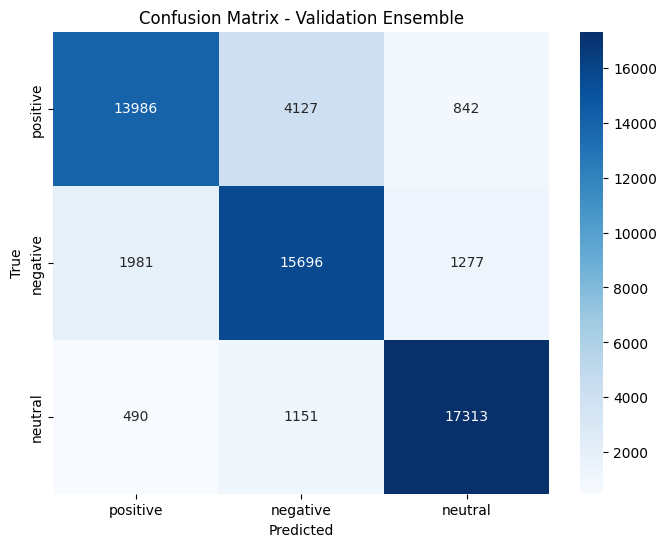

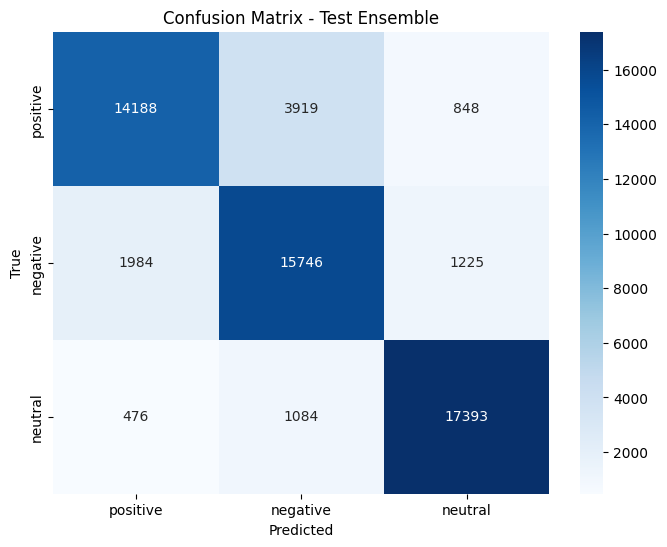

Validation Report Ensemble:
               precision    recall  f1-score   support

           0       0.85      0.74      0.79     18955
           1       0.75      0.83      0.79     18954
           2       0.89      0.91      0.90     18954

    accuracy                           0.83     56863
   macro avg       0.83      0.83      0.83     56863
weighted avg       0.83      0.83      0.83     56863

Test Report Ensemble:
               precision    recall  f1-score   support

           0       0.85      0.75      0.80     18955
           1       0.76      0.83      0.79     18955
           2       0.89      0.92      0.91     18953

    accuracy                           0.83     56863
   macro avg       0.83      0.83      0.83     56863
weighted avg       0.83      0.83      0.83     56863



In [32]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['positive', 'negative', 'neutral']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion(y_val, ensemble_val, "Confusion Matrix - Validation Ensemble")

plot_confusion(y_test, ensemble_test, "Confusion Matrix - Test Ensemble")

print("Validation Report Ensemble:\n", classification_report(y_val, ensemble_val))
print("Test Report Ensemble:\n", classification_report(y_test, ensemble_test))


## apply arabertv02

In [33]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")

label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
df_train['label'] = df_train['sentiment'].map(label_map)
df_val['label'] = df_val['sentiment'].map(label_map)
df_test['label'] = df_test['sentiment'].map(label_map)

def tokenize_data(df, tokenizer, max_length=256):
    return tokenizer(list(df['text']), truncation=True, padding=True, max_length=max_length)
    
train_encodings = tokenize_data(df_train, tokenizer)
val_encodings = tokenize_data(df_val, tokenizer)
test_encodings = tokenize_data(df_test, tokenizer)

print(" Tokenization done!")


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

 Tokenization done!


In [34]:

class ArabicSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [38]:
train_dataset = ArabicSentimentDataset(train_encodings, df_train['label'].tolist())
val_dataset = ArabicSentimentDataset(val_encodings, df_val['label'].tolist())
test_dataset = ArabicSentimentDataset(test_encodings, df_test['label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [39]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = torch.cuda.is_available()

model_name = "aubmindlab/bert-base-arabertv02"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 6
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

patience = 2
patience_counter = 0
best_val_loss = float('inf')

scaler = GradScaler(enabled=use_amp)
accumulation_steps = 4

for epoch in range(num_epochs):
    model.train()
    epoch_loss, correct, total = 0, 0, 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    optimizer.zero_grad()

    for i, batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        with autocast(enabled=use_amp):
            outputs = model(**batch)
            loss = outputs.loss / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            lr_scheduler.step()

        preds = torch.argmax(outputs.logits, dim=-1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)
        epoch_loss += loss.item() * accumulation_steps

        progress_bar.set_postfix(loss=f"{loss.item() * accumulation_steps:.4f}")

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_accuracy = correct / total

    model.eval()
    all_preds, all_labels = [], []
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with autocast(enabled=use_amp):
                outputs = model(**batch)
                loss = outputs.loss
            val_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    current_lr = optimizer.param_groups[0]['lr']

    print(f" Epoch {epoch+1} | Train Loss: {avg_epoch_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Acc: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | LR: {current_lr:.8f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        model.save_pretrained("best_model_dir")
        tokenizer.save_pretrained("best_model_dir")
        print(" Best model and tokenizer saved to best_model_dir")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(" Early stopping triggered!")
            break

print("Training completed!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/1947641322.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)
Epoch 1/6:   0%|          | 0/14216 [00:00<?, ?it/s]/tmp/ipykernel_36/1947641322.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Epoch 1/6: 100%|██████████| 14216/14216 [1:21:20<00:00,  2.91it/s, loss=0.2975]
/tmp/ipykernel_36/1947641322.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with 

 Epoch 1 | Train Loss: 0.2613 | Val Loss: 0.2221 | Train Acc: 0.8910 | Val Acc: 0.9075 | Precision: 0.9081 | Recall: 0.9075 | F1: 0.9073 | LR: 0.00001917
 Best model and tokenizer saved to best_model_dir


Epoch 2/6:   0%|          | 0/14216 [00:00<?, ?it/s]/tmp/ipykernel_36/1947641322.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Epoch 2/6: 100%|██████████| 14216/14216 [1:21:06<00:00,  2.92it/s, loss=0.1804]
/tmp/ipykernel_36/1947641322.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


 Epoch 2 | Train Loss: 0.1914 | Val Loss: 0.2176 | Train Acc: 0.9221 | Val Acc: 0.9138 | Precision: 0.9140 | Recall: 0.9138 | F1: 0.9136 | LR: 0.00001833
 Best model and tokenizer saved to best_model_dir


Epoch 3/6:   0%|          | 0/14216 [00:00<?, ?it/s]/tmp/ipykernel_36/1947641322.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Epoch 3/6: 100%|██████████| 14216/14216 [1:21:11<00:00,  2.92it/s, loss=0.3291]
/tmp/ipykernel_36/1947641322.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


 Epoch 3 | Train Loss: 0.1533 | Val Loss: 0.2269 | Train Acc: 0.9384 | Val Acc: 0.9133 | Precision: 0.9136 | Recall: 0.9133 | F1: 0.9134 | LR: 0.00001750


Epoch 4/6:   0%|          | 0/14216 [00:00<?, ?it/s]/tmp/ipykernel_36/1947641322.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Epoch 4/6: 100%|██████████| 14216/14216 [1:21:04<00:00,  2.92it/s, loss=0.0913]
/tmp/ipykernel_36/1947641322.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


 Epoch 4 | Train Loss: 0.1199 | Val Loss: 0.2424 | Train Acc: 0.9529 | Val Acc: 0.9140 | Precision: 0.9139 | Recall: 0.9140 | F1: 0.9139 | LR: 0.00001667
 Early stopping triggered!
Training completed!


/tmp/ipykernel_36/2978834584.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):



 Test Results | Accuracy: 0.9147 | Precision: 0.9147 | Recall: 0.9147 | F1 Score: 0.9144

 Detailed Classification Report:

              precision    recall  f1-score   support

     neutral       0.92      0.88      0.90     18955
    negative       0.88      0.90      0.89     18955
    positive       0.94      0.97      0.95     18953

    accuracy                           0.91     56863
   macro avg       0.91      0.91      0.91     56863
weighted avg       0.91      0.91      0.91     56863



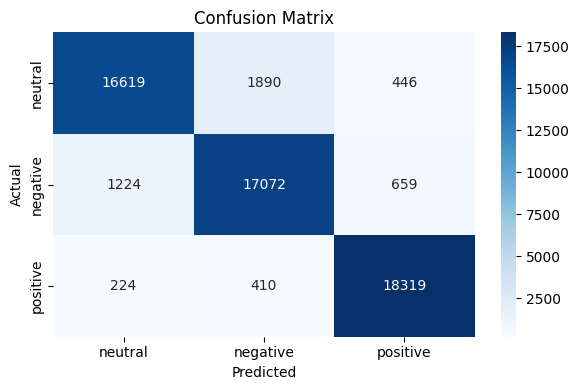

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("best_model_dir").to(device)
tokenizer = AutoTokenizer.from_pretrained("best_model_dir")
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with autocast(enabled=use_amp):
            outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"\n Test Results | Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")

label_map = {0: " positive", 1: "negative", 2: "neutral"}  
print("\n Detailed Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_map.values()))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.values(), yticklabels=label_map.values(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()